In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import os
from torchvision import models
import matplotlib.pyplot as plt

data_path = "."

### Sanity Check for GPU Runtime

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # use gpu if available
# print device name if using gpu with message "Using GPU: device_name"
if device.type == "cuda":
    print("Using GPU: {}".format(torch.cuda.get_device_name(0)))


Using GPU: Tesla T4


### Connecting to googledrive

In [4]:
# Optional for those utilizing google colab
from google.colab import drive
import os

drive.mount('/content/drive')

# Specify the path of the uploaded dataset in your Google Drive
dataset_path = "/content/drive/MyDrive/ML/"
if os.path.exists(dataset_path):
    print("The file exists.")
else:
    print("The file does not exist.")

data_path = dataset_path

Mounted at /content/drive
The file exists.


In [5]:
# Define the directories where your images are stored
covid_dir = f"{data_path}/dataset_14/covid"
normal_dir = f"{data_path}/dataset_14/normal"

### Exploratory Data Analysis

<ipython-input-6-1813455abde4>:14: FutureWarning: The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  covid_image_data = np.array(covid_image_data)
<ipython-input-6-1813455abde4>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  covid_image_data = np.array(covid_image_data)
<ipython-input-6-1813455abde4>:15: FutureWarning: The input object of type 'PngImageFile' is an array-

Text(0, 0.5, '# Images')

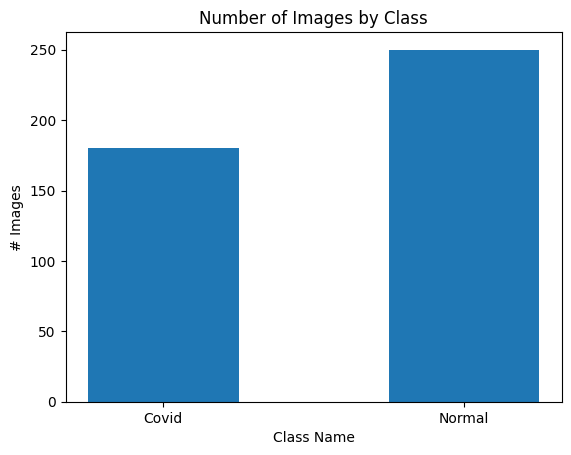

In [6]:
import matplotlib.pyplot as plt
import numpy as np

covid_image_data = []
norm_image_data = []

for filename in os.listdir(covid_dir):
    img = Image.open(os.path.join(covid_dir, filename))
    covid_image_data.append(img)
for filename in os.listdir(normal_dir):
    img = Image.open(os.path.join(normal_dir, filename))
    norm_image_data.append(img)

covid_image_data = np.array(covid_image_data)
norm_image_data = np.array(norm_image_data)

# Comparing Dataset size
Num_Covid = np.size(covid_image_data)
Num_Normal = np.size(norm_image_data)
plt.bar(["Covid", "Normal"] , [Num_Covid, Num_Normal], width = .5)
plt.title("Number of Images by Class")
plt.xlabel('Class Name')
plt.ylabel('# Images')

<ipython-input-7-3eb48ca7c825>:13: FutureWarning: The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  covid_image_data = np.array(covid_image_data)
<ipython-input-7-3eb48ca7c825>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  covid_image_data = np.array(covid_image_data)
<ipython-input-7-3eb48ca7c825>:14: FutureWarning: The input object of type 'PngImageFile' is an array-

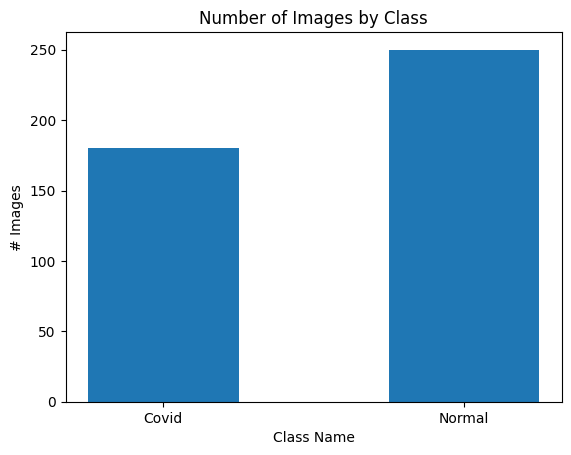

In [7]:
import matplotlib.pyplot as plt

covid_image_data = []
norm_image_data = []

for filename in os.listdir(covid_dir):
    img = Image.open(os.path.join(covid_dir, filename))
    covid_image_data.append(img)
for filename in os.listdir(normal_dir):
    img = Image.open(os.path.join(normal_dir, filename))
    norm_image_data.append(img)

covid_image_data = np.array(covid_image_data)
norm_image_data = np.array(norm_image_data)

# Comparing Dataset size
Num_Covid = np.size(covid_image_data)
Num_Normal = np.size(norm_image_data)
plt.bar(["Covid", "Normal"] , [Num_Covid, Num_Normal], width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

### Transform and Split the Dataset


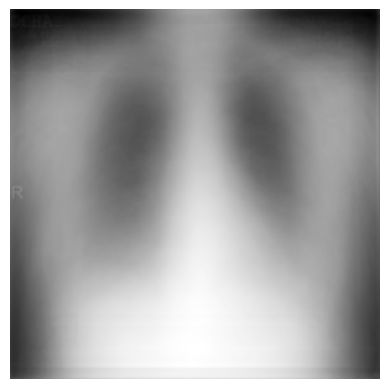

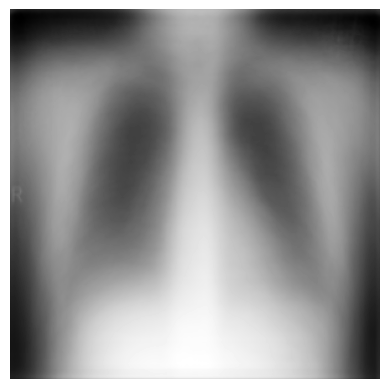

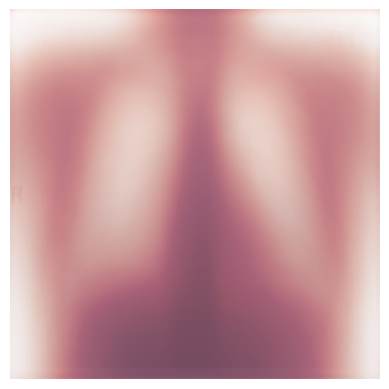

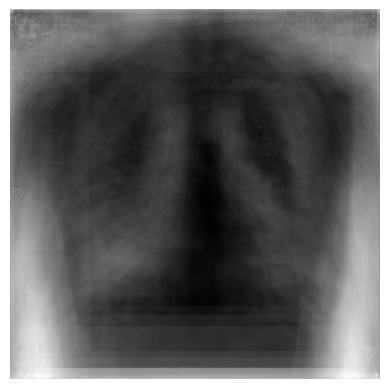

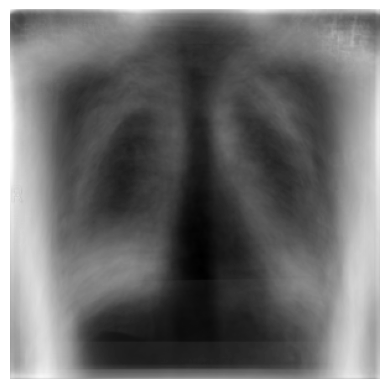

In [8]:
covid_image_data
norm_image_data

covid_data = []
norm_data = []

for data in covid_image_data:
  arr = np.array(data)
  covid_data.append(arr)
for data in norm_image_data:
  arr = np.array(data)
  norm_data.append(arr)

covid_mean = np.mean(covid_data, axis=0)
plt.imshow(covid_mean, cmap='gray')
plt.axis('off')  # Remove the axis ticks and labels
plt.show()

norm_mean = np.mean(norm_data, axis=0)
plt.imshow(norm_mean, cmap='gray')
plt.axis('off')  # Remove the axis ticks and labels
plt.show()

plt.imshow(covid_mean, cmap='Blues', alpha=0.5)
plt.imshow(norm_mean, cmap='Reds', alpha=0.5)
plt.axis('off')
plt.show()

covid_std = np.std(covid_data, axis=0)
plt.imshow(covid_std, cmap='gray')
plt.axis('off')  # Remove the axis ticks and labels
plt.show()

norm_std = np.std(norm_data, axis=0)
plt.imshow(norm_std, cmap='gray')
plt.axis('off')  # Remove the axis ticks and labels
plt.show()

In [9]:
# Define the directories where your images are stored
covid_dir = f"{data_path}/dataset_14/covid"
normal_dir = f"{data_path}/dataset_14/normal"

# Data augmentation
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize in range [-1,1]
])

# Define a function to load and preprocess images
def load_and_preprocess_image(file_path):
    # Open the image file
    with Image.open(file_path) as img:
        # Apply the transformations
        img_transformed = transform_train(img)  # use transform_train instead of transform
    return img_transformed

# Load and preprocess all images
data = []
labels = []
for filename in os.listdir(covid_dir):
    img_tensor = load_and_preprocess_image(os.path.join(covid_dir, filename))
    data.append(img_tensor)
    labels.append(1)  # '1' for 'covid'
for filename in os.listdir(normal_dir):
    img_tensor = load_and_preprocess_image(os.path.join(normal_dir, filename))
    data.append(img_tensor)
    labels.append(0)  # '0' for 'normal'

# Convert the data and labels to PyTorch tensors
data = torch.stack(data)
labels = torch.tensor(labels)

# First, split the data into a training set and a temporary set using an 80-20 split
train_data, temp_data, train_labels, temp_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Then, split the temporary set into a validation set and a test set using a 50-50 split
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42)

In [10]:
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Number of images in the training set
num_train_images = len(train_dataset)
print("Number of images in the training set:", num_train_images)

# Number of images in the validation set
num_val_images = len(val_dataset)
print("Number of images in the validation set:", num_val_images)

# Number of images in the test set
num_test_images = len(test_dataset)
print("Number of images in the test set:", num_test_images)

Number of images in the training set: 344
Number of images in the validation set: 43
Number of images in the test set: 43


### Create DataLoaders

In [11]:
# Create DataLoaders
batch_size = 32 # Parameter: batch size
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Naive Bayes

In [12]:
import numpy as np
from sklearn.naive_bayes import GaussianNB

# Extract histogram-based features
def extract_features(data):
    features = []
    for image in data:
        hist_r, _ = np.histogram(image[0].numpy().ravel(), bins=256, range=[0, 256])
        hist_g, _ = np.histogram(image[1].numpy().ravel(), bins=256, range=[0, 256])
        hist_b, _ = np.histogram(image[2].numpy().ravel(), bins=256, range=[0, 256])
        features.append(np.concatenate([hist_r, hist_g, hist_b]))
    return np.array(features)

# Extract features from the datasets
train_features = extract_features(train_data)
val_features = extract_features(val_data)
test_features = extract_features(test_data)

# Train the Naive Bayes classifier
clf = GaussianNB()
clf.fit(train_features, train_labels.numpy())

# Evaluate on the validation set
val_predictions = clf.predict(val_features)
val_accuracy = np.mean(val_predictions == val_labels.numpy())

# Evaluate on the test set
test_predictions = clf.predict(test_features)
test_accuracy = np.mean(test_predictions == test_labels.numpy())

print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)

Validation Accuracy: 0.4883720930232558
Test Accuracy: 0.6744186046511628


### SVM

In [13]:
import numpy as np
from sklearn import svm

# Flatten the image tensors and convert them to numpy arrays
train_data_flat = train_data.view(train_data.size(0), -1).numpy()
val_data_flat = val_data.view(val_data.size(0), -1).numpy()
test_data_flat = test_data.view(test_data.size(0), -1).numpy()

# Convert labels to numpy arrays
train_labels_np = train_labels.numpy()
val_labels_np = val_labels.numpy()
test_labels_np = test_labels.numpy()

# Create and train the SVM classifier
clf = svm.SVC(kernel='linear')  # You can choose a different kernel if needed
clf.fit(train_data_flat, train_labels_np)

# Evaluate the classifier on the validation set
val_predictions = clf.predict(val_data_flat)
val_accuracy = np.mean(val_predictions == val_labels_np)
print("Validation Accuracy:", val_accuracy)

# Evaluate the classifier on the test set
test_predictions = clf.predict(test_data_flat)
test_accuracy = np.mean(test_predictions == test_labels_np)
print("Test Accuracy:", test_accuracy)

Validation Accuracy: 0.6744186046511628
Test Accuracy: 0.7209302325581395


### MLP

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the MLP architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(224 * 224 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)  # 2 output classes (covid, normal)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create the MLP model
mlp = MLP()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.001, momentum=0.9)

# Train the MLP
num_epochs = 10  # Number of training epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp.to(device)

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0

    mlp.train()  # Set the model to training mode

    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = mlp(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataloader)
    train_accuracy = train_correct / len(train_dataset)

    # Evaluate on the validation set
    mlp.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = mlp(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_dataloader)
    val_accuracy = val_correct / len(val_dataset)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Evaluate the trained MLP on the test set
mlp.eval()
test_correct = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = mlp(images)
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / len(test_dataset)
print("Test Accuracy:", test_accuracy)

Epoch 1/10: Train Loss: 0.6696, Train Accuracy: 0.5901, Val Loss: 0.7412, Val Accuracy: 0.4419
Epoch 2/10: Train Loss: 0.5844, Train Accuracy: 0.7122, Val Loss: 0.7074, Val Accuracy: 0.6047
Epoch 3/10: Train Loss: 0.5393, Train Accuracy: 0.7238, Val Loss: 0.5687, Val Accuracy: 0.6512
Epoch 4/10: Train Loss: 0.4912, Train Accuracy: 0.7762, Val Loss: 0.6270, Val Accuracy: 0.6279
Epoch 5/10: Train Loss: 0.4352, Train Accuracy: 0.8023, Val Loss: 0.4381, Val Accuracy: 0.7674
Epoch 6/10: Train Loss: 0.4023, Train Accuracy: 0.8547, Val Loss: 0.5921, Val Accuracy: 0.7442
Epoch 7/10: Train Loss: 0.3826, Train Accuracy: 0.8430, Val Loss: 0.4644, Val Accuracy: 0.8140
Epoch 8/10: Train Loss: 0.3569, Train Accuracy: 0.8547, Val Loss: 0.3784, Val Accuracy: 0.8837
Epoch 9/10: Train Loss: 0.2984, Train Accuracy: 0.8895, Val Loss: 0.6758, Val Accuracy: 0.7209
Epoch 10/10: Train Loss: 0.2662, Train Accuracy: 0.9302, Val Loss: 0.3434, Val Accuracy: 0.8605
Test Accuracy: 0.7441860465116279


### CNN


Epoch 1/30: Train Loss: 0.7364, Train Accuracy: 0.6279, Val Loss: 0.6664, Val Accuracy: 0.6047
Epoch 2/30: Train Loss: 0.6472, Train Accuracy: 0.7267, Val Loss: 0.7252, Val Accuracy: 0.6047
Epoch 3/30: Train Loss: 0.5978, Train Accuracy: 0.7674, Val Loss: 0.9466, Val Accuracy: 0.6047
Epoch 4/30: Train Loss: 0.3505, Train Accuracy: 0.8634, Val Loss: 0.3935, Val Accuracy: 0.8140
Epoch 5/30: Train Loss: 0.2296, Train Accuracy: 0.8924, Val Loss: 0.2696, Val Accuracy: 0.7674
Epoch 6/30: Train Loss: 0.1728, Train Accuracy: 0.9244, Val Loss: 0.4278, Val Accuracy: 0.8605
Epoch 7/30: Train Loss: 0.0786, Train Accuracy: 0.9855, Val Loss: 0.4891, Val Accuracy: 0.8372
Epoch 8/30: Train Loss: 0.0673, Train Accuracy: 0.9797, Val Loss: 0.2752, Val Accuracy: 0.8605
Epoch 9/30: Train Loss: 0.0354, Train Accuracy: 0.9913, Val Loss: 0.1729, Val Accuracy: 0.9070
Epoch 10/30: Train Loss: 0.0163, Train Accuracy: 1.0000, Val Loss: 0.2258, Val Accuracy: 0.8837
Epoch 11/30: Train Loss: 0.0196, Train Accuracy: 

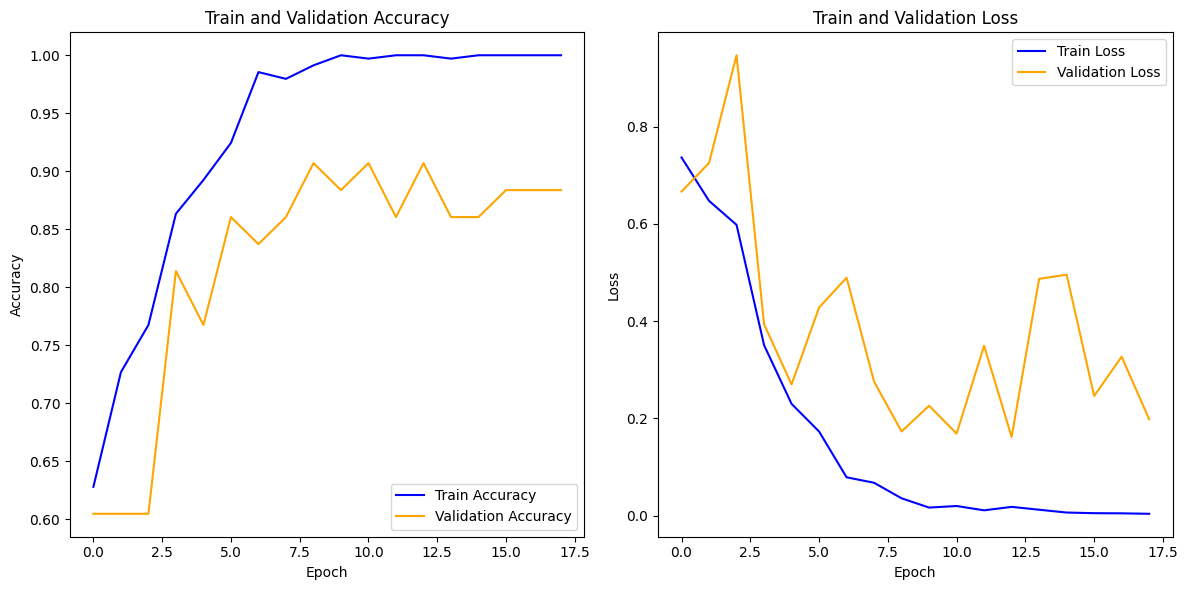

In [35]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 2),  # Changed K to 2
        )

    def forward(self, X):
        out = self.conv_layers(X)

    # Flatten the output of the conv layers
        out = out.view(out.size(0), -1)

    # Fully connected
        out = self.dense_layers(out)
        return out

net = CNN()
net = net.to(device) # move the network to GPU if available

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,
                      weight_decay = 0.01)

# Train the CNN
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 30  # Number of training epochs
patience = 5  # number of epochs to wait before stopping if no improvement
early_stopping_wait = 0
best_val_loss = float('inf')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0

    net.train()  # Set the model to training mode

    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataloader)
    train_accuracy = train_correct / len(train_dataset)

    # Append train metrics after calculation
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on the validation set
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_dataloader)
    val_accuracy = val_correct / len(val_dataset)

    # Append validation metrics after calculation
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # At the end of each epoch, after the validation
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(net.state_dict(), '/content/drive/MyDrive/ML/CNN.pth')
        early_stopping_wait = 0
    else:
        early_stopping_wait += 1
        if early_stopping_wait >= patience:
            print("Early stopping")
            break  # breaks out of the for loop for the epochs

# Evaluate the trained CNN on the test set
net.eval()
test_correct = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / len(test_dataset)
print("Test Accuracy:", test_accuracy)

# Plot the training accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_accuracies)), train_accuracies, color='blue', label='Train Accuracy')
plt.plot(range(len(val_accuracies)), val_accuracies, color='orange', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(len(train_losses)), train_losses, color='blue', label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, color='orange', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()




### Confusion Matrix for results evaluation

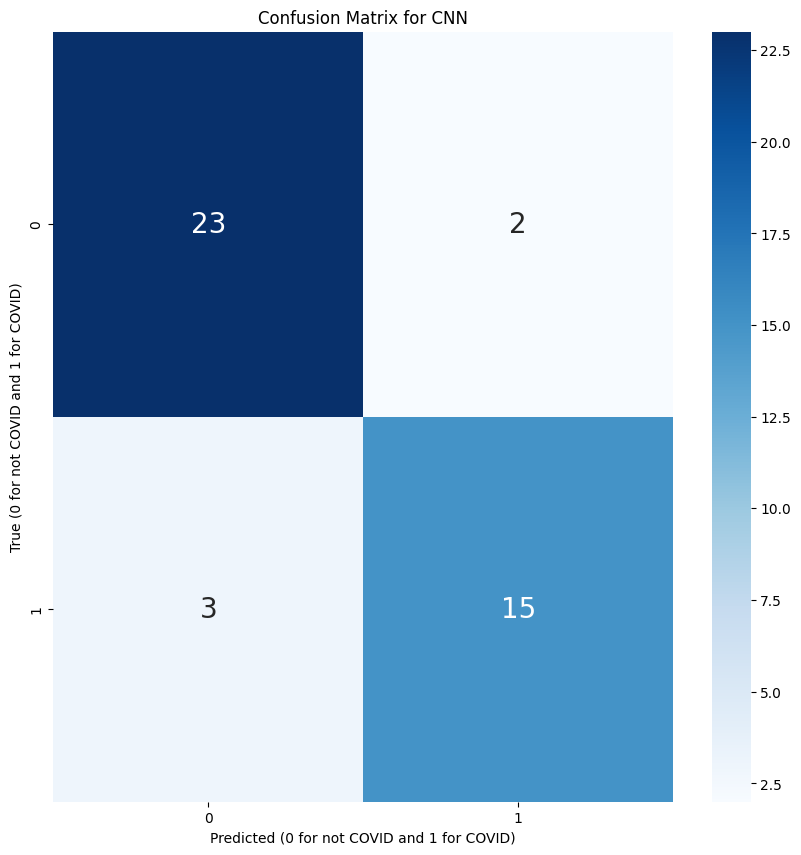

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Initialize lists to hold labels and predictions
true_labels = []
pred_labels = []

# Iterate through test set and make predictions
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',annot_kws={"size": 20})
plt.xlabel('Predicted (0 for not COVID and 1 for COVID)')
plt.ylabel('True (0 for not COVID and 1 for COVID)')
plt.title('Confusion Matrix for CNN')
plt.show()


### Further Error Analysis

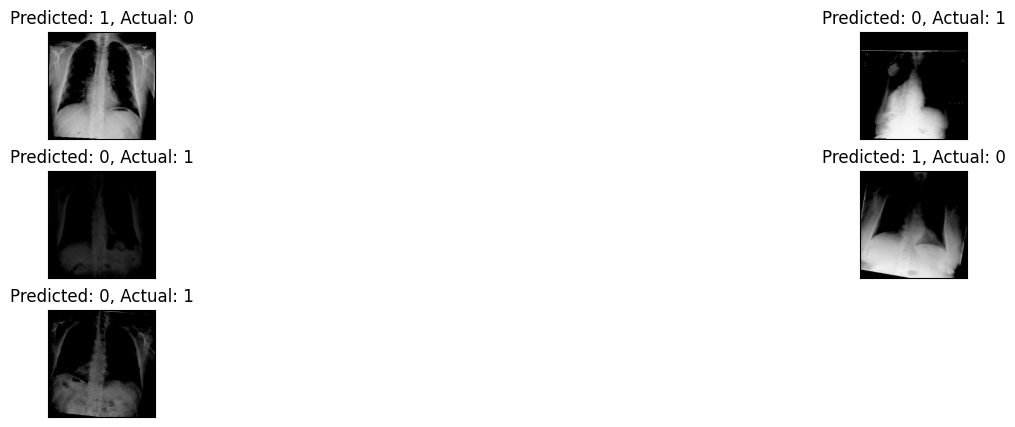

In [37]:
# Initialize lists to hold images, predictions and labels
incorrect_imgs = []
incorrect_labels = []
incorrect_preds = []

# Move through the entire test dataset
for images, labels in test_dataloader:
    # Move model inputs to cuda, if GPU available
    if torch.cuda.is_available():
        images = images.cuda()

    # Get sample outputs
    output = net(images)

    # Convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())

    # Check which indices are incorrect
    incorrect_idx = np.where(preds != labels.cpu().numpy())[0]

    # Append the incorrect images, labels and predictions to the respective lists
    incorrect_imgs.extend(images[incorrect_idx].cpu())
    incorrect_labels.extend(labels[incorrect_idx].cpu().numpy())
    incorrect_preds.extend(preds[incorrect_idx])

# Convert the lists to numpy arrays for easier handling
incorrect_imgs = [img.numpy() for img in incorrect_imgs]
incorrect_labels = np.array(incorrect_labels)
incorrect_preds = np.array(incorrect_preds)

# Plot the misclassified images
fig = plt.figure(figsize=(20, 5))  # Adjust figure size here
plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Adjust space between subplots here

for idx in range(len(incorrect_imgs)):
    ax = fig.add_subplot(3, len(incorrect_imgs) // 2, idx+1, xticks=[], yticks=[])
    img = incorrect_imgs[idx]
    img = img.transpose(1, 2, 0)  # Reshape images
    ax.imshow(np.clip(img, 0, 1), cmap='gray')
    ax.set_title(f"Predicted: {incorrect_preds[idx]}, Actual: {incorrect_labels[idx]}")

plt.show()



## Transfer Learning with VGG-16

In [22]:
# Load pre-trained VGG16 model
net = models.vgg16(pretrained=True)
# net = models.vgg16(weights=None)


# Modify the last layer
num_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(num_features, 2)  # '2' for 'covid' and 'normal'

# Move model to GPU if available
net = net.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# initialize tensorboard
writer = SummaryWriter('runs/covid_classifier_experiment_1')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 157MB/s] 


### Training Loop


Epoch 1/30: Train Loss: 0.0007, Train Accuracy: 100.0000, Val Loss: 0.0832, Val Accuracy: 97.6744
Epoch 2/30: Train Loss: 0.0008, Train Accuracy: 100.0000, Val Loss: 0.0368, Val Accuracy: 97.6744
Epoch 3/30: Train Loss: 0.0018, Train Accuracy: 100.0000, Val Loss: 0.0797, Val Accuracy: 97.6744
Epoch 4/30: Train Loss: 0.0007, Train Accuracy: 100.0000, Val Loss: 0.1114, Val Accuracy: 97.6744
Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/30: Train Loss: 0.0008, Train Accuracy: 100.0000, Val Loss: 0.0383, Val Accuracy: 97.6744
Epoch 6/30: Train Loss: 0.0008, Train Accuracy: 100.0000, Val Loss: 0.0337, Val Accuracy: 97.6744
Epoch 7/30: Train Loss: 0.0005, Train Accuracy: 100.0000, Val Loss: 0.0312, Val Accuracy: 97.6744
Epoch 8/30: Train Loss: 0.0009, Train Accuracy: 100.0000, Val Loss: 0.0760, Val Accuracy: 97.6744
Epoch 9/30: Train Loss: 0.0007, Train Accuracy: 100.0000, Val Loss: 0.0458, Val Accuracy: 97.6744
Epoch 00009: reducing learning rate of group 0 to 1.0000

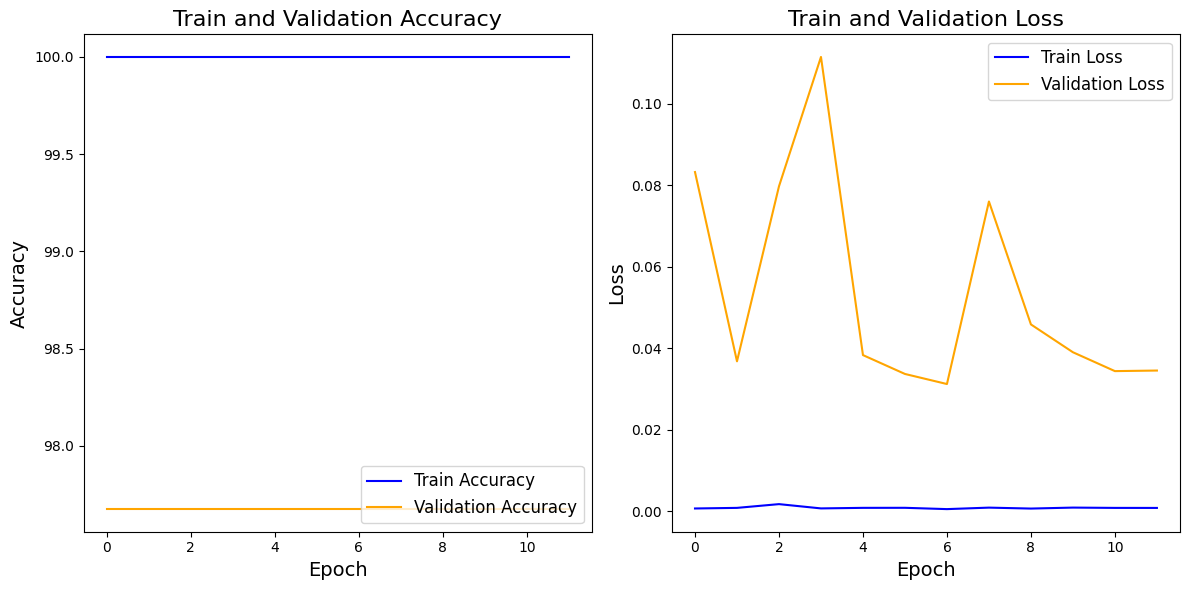

In [31]:
from torch.optim import lr_scheduler

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
patience = 5
early_stop_counter = 0
best_val_loss = float('inf')

# Use weight decay in the optimizer for L2 regularization
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

# Define a learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

# Train the model
for epoch in range(30):  # loop over the dataset multiple times
    net.train()  # ensure the model is in training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)



    # Validation loop
    net.eval()  # ensure the model is in evaluation mode
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data in val_dataloader:
            images, labels = data[0].to(device), data[1].to(device)

            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_dataloader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping")
            break

    # Step with the scheduler
    scheduler.step(val_loss)



# Evaluate the trained CNN on the test set
net.eval()
test_correct = 0

with torch.no_grad():
  for images, labels in test_dataloader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / len(test_dataset)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 6))

# Training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(range(len(train_accuracies)), train_accuracies, color='blue', label='Train Accuracy')
plt.plot(range(len(val_accuracies)), val_accuracies, color='orange', label='Validation Accuracy')
plt.title('Train and Validation Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(len(train_losses)), train_losses, color='blue', label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, color='orange', label='Validation Loss')
plt.title('Train and Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()


### Confusion Matrix with VGG16

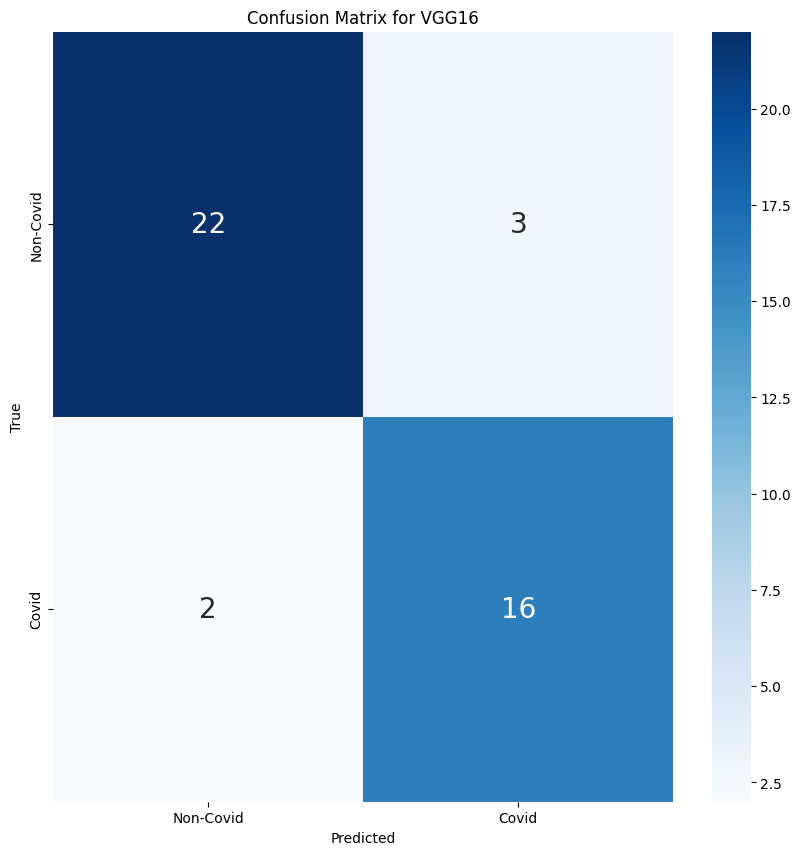

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model with the test data to create the confusion matrix after training and validation
net.eval()  # ensure the model is in evaluation mode
all_labels = []
all_predictions = []

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Create a confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["Non-Covid", "Covid"], yticklabels=["Non-Covid", "Covid"],annot_kws={"size": 20})
plt.title('Confusion Matrix for VGG16')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

### See what was misclassified

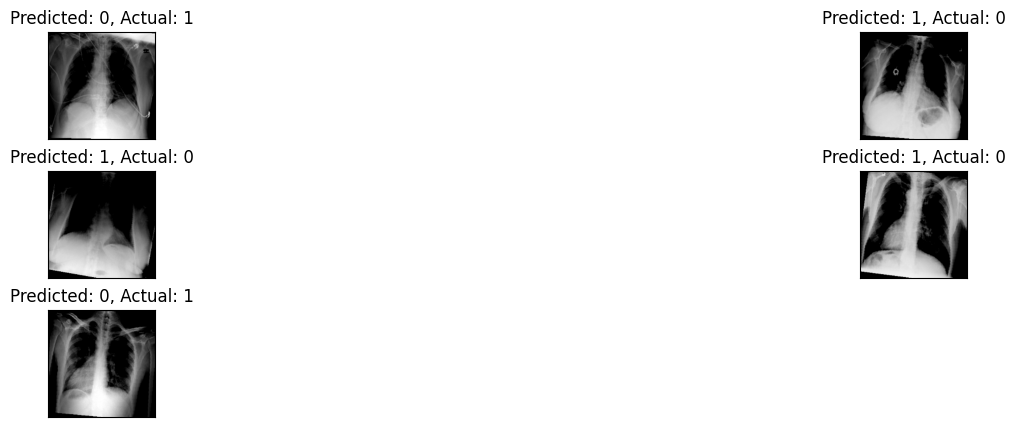

In [34]:
# Initialize lists to hold images, predictions and labels
incorrect_imgs = []
incorrect_labels = []
incorrect_preds = []

# Move through the entire test dataset
for images, labels in test_dataloader:
    # Move model inputs to cuda, if GPU available
    if torch.cuda.is_available():
        images = images.cuda()

    # Get sample outputs
    output = net(images)

    # Convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())

    # Check which indices are incorrect
    incorrect_idx = np.where(preds != labels.cpu().numpy())[0]

    # Append the incorrect images, labels and predictions to the respective lists
    incorrect_imgs.extend(images[incorrect_idx].cpu())
    incorrect_labels.extend(labels[incorrect_idx].cpu().numpy())
    incorrect_preds.extend(preds[incorrect_idx])

# Convert the lists to numpy arrays for easier handling
incorrect_imgs = [img.numpy() for img in incorrect_imgs]
incorrect_labels = np.array(incorrect_labels)
incorrect_preds = np.array(incorrect_preds)

# Plot the misclassified images
fig = plt.figure(figsize=(20, 5))  # Adjust figure size here
plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Adjust space between subplots here

for idx in range(len(incorrect_imgs)):
    ax = fig.add_subplot(3, len(incorrect_imgs) // 2, idx+1, xticks=[], yticks=[])
    img = incorrect_imgs[idx]
    img = img.transpose(1, 2, 0)  # Reshape images
    ax.imshow(np.clip(img, 0, 1), cmap='gray')
    ax.set_title(f"Predicted: {incorrect_preds[idx]}, Actual: {incorrect_labels[idx]}")

plt.show()



### Test the network on the test data

In [ ]:

# Accuracy test and image comparison on validation set
correct = 0
total = 0
with torch.no_grad():
        for data in val_dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Add image comparisons to TensorBoard
        img_grid = torchvision.utils.make_grid(images)
        writer.add_image('covid_vs_normal', img_grid)

        writer.add_scalar('Accuracy/validation', 100 * correct / total, epoch)
        writer.add_scalar('Loss/validation', running_loss, epoch)

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))


### GNN

In [ ]:
# Define the directories where your images are stored
covid_dir = f"{data_path}/dataset_14/covid"
normal_dir = f"{data_path}/dataset_14/normal"

# Data augmentation
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to single channel
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize in range [-1,1]
])

# Define a function to load and preprocess images
def load_and_preprocess_image(file_path):
    # Open the image file
    with Image.open(file_path) as img:
        # Apply the transformations
        img_transformed = transform_train(img)  # use transform_train instead of transform
    return img_transformed

# Load and preprocess all images
data = []
labels = []
for filename in os.listdir(covid_dir):
    img_tensor = load_and_preprocess_image(os.path.join(covid_dir, filename))
    data.append(img_tensor)
    labels.append(1)  # '1' for 'covid'
for filename in os.listdir(normal_dir):
    img_tensor = load_and_preprocess_image(os.path.join(normal_dir, filename))
    data.append(img_tensor)
    labels.append(0)  # '0' for 'normal'

# Convert the data and labels to PyTorch tensors
data = torch.stack(data)
labels = torch.tensor(labels)

# First, split the data into a training set and a temporary set using an 80-20 split
train_data, temp_data, train_labels, temp_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Then, split the temporary set into a validation set and a test set using a 50-50 split
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42)

train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Create DataLoaders
batch_size = 4 # Parameter: batch size
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from scipy.spatial.distance import cdist

class BorisGraphNet(nn.Module):
    def __init__(self, img_size=128, pred_edge=False):
        super(BorisGraphNet, self).__init__()
        self.pred_edge = pred_edge
        N = img_size ** 2
        self.fc = nn.Linear(N, 2, bias=False)
        if pred_edge:
            col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
            coord = np.stack((col, row), axis=2).reshape(-1, 2)
            coord = (coord - np.mean(coord, axis=0)) / (np.std(coord, axis=0) + 1e-5)
            coord = torch.from_numpy(coord).float()
            coord = torch.cat((coord.unsqueeze(0).repeat(N, 1,  1),
                                    coord.unsqueeze(1).repeat(1, N, 1)), dim=2)
            self.pred_edge_fc = nn.Sequential(nn.Linear(4, 64),
                                              nn.ReLU(),
                                              nn.Linear(64, 1),
                                              nn.Tanh())
            self.register_buffer('coord', coord)
        else:
            A = self.precompute_adjacency_images(img_size)
            self.register_buffer('A', A)

    @staticmethod
    def precompute_adjacency_images(img_size):
        col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
        coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
        dist = cdist(coord, coord)
        sigma = 0.05 * np.pi
        A = np.exp(-dist / sigma ** 2)
        A[A < 0.01] = 0
        A = torch.from_numpy(A).float()
        D = A.sum(1)
        D_hat = (D + 1e-5) ** (-0.5)
        A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)
        A_hat[A_hat > 0.0001] = A_hat[A_hat > 0.0001] - 0.2
        return A_hat

    def forward(self, x):
        B = x.size(0)
        if self.pred_edge:
            self.A = self.pred_edge_fc(self.coord).squeeze()
        avg_neighbor_features = torch.bmm(self.A.unsqueeze(0).expand(B, -1, -1), x.view(B, -1, 1)).view(B, -1)
        return self.fc(avg_neighbor_features)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BorisGraphNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return total_loss / len(dataloader), 100.0 * correct / total

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # print(outputs)
            # print(outputs[0], labels[0])
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return total_loss / len(dataloader), 100.0 * correct / total

num_epochs = 30

for epoch in range(num_epochs):
    print("training")
    train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion)
    print("val")
    val_loss, val_accuracy = evaluate(model, val_dataloader, criterion)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

test_loss, test_accuracy = evaluate(model, test_dataloader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")